# Reinforcement Learning - TicTacToe

Developed a Tic Tac Toe agent using reinforcement learning principles to learn optimal strategies through self-play. Implemented state-value functions and reward-based updates using the ε-greedy policy to balance exploration and exploitation. The agent improves over time by evaluating board states and learning from outcomes, ultimately achieving near-perfect play against both random and human opponents.

Key Concepts: State-value estimation, policy improvement, exploration vs. exploitation, reward-based learning <br>
Tools Used: Python, NumPy

## Import Libraries

In [1]:
import time
start = time.time()

In [2]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import seaborn as sns
from math import ceil

# Random Seed
np.random.seed(42)

## Game Board

In [3]:
global gameBoard
gameBoard = np.array(['X'] *  9).reshape((3, 3))

## Rewards

In [4]:
global REWARD_ON_WIN, REWARD_ON_LOSS, REWARD_ON_DRAW, REWARD_NEUTRAL_STATE
REWARD_ON_WIN, REWARD_ON_LOSS, REWARD_ON_DRAW, REWARD_ON_NEUTRAL_STATE = 1, -2, -0.1, 0

## Helper Functions

In [5]:
def isValidMove(board, position):
    """
    Checks whether the next move is valid.
    
    Parameters:
        board (np.ndarray): The current Tic Tac Toe game board.
        position (tuple): The (row, column) position of the intended move.

    Returns:
        bool: True if the move is valid, False otherwise.
    """
    x, y = position[0], position[1]
    if(board[x][y] == 'X'):
        return True
    return False

In [6]:
def getGameStatus(board, symbol):
    """
    Determines the current status of the Tic Tac Toe game for the given player.

    Parameters:
        board (np.ndarray): A 3x3 NumPy array representing the current game board.
        symbol (int): The symbol of the current player (typically 0 or 1).

    Returns:
        int: 
            1 if the player has won,  
            0 if the game ended in a draw,  
           -1 if the game is still ongoing.
    """
    symbol = str(symbol)
    if(board[0][0] == symbol and board[0][1] == symbol and board[0][2] == symbol):
        return 1
    elif(board[1][0] == symbol and board[1][1] == symbol and board[1][2] == symbol):
        return 1
    elif(board[2][0] == symbol and board[2][1] == symbol and board[2][2] == symbol):
        return 1
    elif(board[0][0] == symbol and board[1][0] == symbol and board[2][0] == symbol):
        return 1
    elif(board[0][1] == symbol and board[1][1] == symbol and board[2][1] == symbol):
        return 1
    elif(board[0][2] == symbol and board[1][2] == symbol and board[2][2] == symbol):
        return 1
    elif(board[0][0] == symbol and board[1][1] == symbol and board[2][2] == symbol):
        return 1
    elif(board[0][2] == symbol and board[1][1] == symbol and board[2][0] == symbol):
        return 1
    elif not np.any(np.vectorize(lambda x: x == 'X')(board)):
        return 0
    return -1

In [7]:
def applyMove(board, position, symbol):
    """
    Applies the player's move to the Tic Tac Toe board.

    Parameters:
        board (np.ndarray): A 3x3 NumPy array representing the current game board.
        position (tuple): A tuple (row, column) indicating the move's target cell.
        symbol (int): The symbol representing the player (e.g., 0 or 1).

    Returns:
        np.ndarray: A new board with the move applied at the specified position.
    """
    
    x, y = position[0], position[1]
    board[x][y] = symbol
    return board

In [8]:
def makeRandomMove(board, symbol):
    """
    Applies a single random move to the Tic Tac Toe board by selecting an 
    empty position and placing the given player's symbol.

    Parameters:
        board (np.ndarray): A 3x3 NumPy array representing the current game board,
                            where empty cells are marked as None.
        symbol (int): The symbol representing the player (e.g., 0 or 1).

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The board after one random move has been applied.
            - tuple: The (row, column) coordinates of the move.
    """
    emptyPositions = []
    for i in range(0, len(board)):
        for j in range(0, len(board)):
            if(board[i][j] == 'X'):
                emptyPositions.append((i, j))
    choice = np.random.choice(np.arange(len(emptyPositions)))
    x, y = emptyPositions[choice][0], emptyPositions[choice][1]
    board[x][y] = symbol
    return board, (x, y)

In [9]:
def makeBestMove(qTable, boardString, board, symbol):
    """
    Applies the best possible move for the current player based on Q-values 
    from the Q-table and returns the updated game board.

    Parameters:
        qTable (dict): A dictionary representing the Q-table, where keys are 
                       board state strings and values are lists of Q-values for each position.
        board (np.ndarray): A 3x3 NumPy array representing the current game board, 
                            where empty cells are marked as None.
        boardString (str): The string representation of the current board state, 
                           used to look up Q-values in the Q-table.
        symbol (int): The symbol representing the current player (e.g., 0 or 1).

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The board after one random move has been applied.
            - tuple: The (row, column) coordinates of the move.
    """
    emptyPositions = []
    for i in range(0, len(board.flat)):
        if(board[i // 3][i % 3] == 'X'):
            emptyPositions.append(i)
    positions = []
    maxQValue = -np.inf
    for i in emptyPositions:
        if(qTable[boardString][i] > maxQValue):
            positions = [i]
            maxQValue = qTable[boardString][i]
        elif(qTable[boardString][i] == maxQValue):
            positions.append(i)
    choice = np.random.choice(positions)
    x, y = choice // 3, choice % 3
    board[x][y] = symbol
    return board, (x, y)

In [10]:
def getBoardString(board):
    """
    Converts a 3x3 Tic Tac Toe board into a flat string representation for use 
    as a unique key in the Q-table.

    Parameters:
        board (np.ndarray): A 3x3 NumPy array representing the current game board, 
                            where each cell contains a symbol (e.g., 0, 1, or None).

    Returns:
        str: A string representation of the board's flattened state, used for 
             indexing or storing values in the Q-table.
    """
    
    string = ""
    for x in board.flat:
        string = string + str(x)
    return string

This function updates the Q-table using Temporal Difference Learning (TD(0)), a core technique in reinforcement learning. It takes the full episode history (episodes) and backpropagates the final reward through all visited state-action pairs.

The agent learns to estimate the long-term value of actions based on observed rewards and future expectations. Each Q-value is updated based on:
- The current estimate
- The final reward
- The estimated value of the next state

This helps the agent improve its decision-making over time.

<b> Q-Learning Update Formula <b>

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Where:
- $ \text{Q(s,a)} $: current Q-value for state s and action a
- $ \alpha $: learning rate (how much to update)
- $ r $: reward received at the end of the episode
- $ \gamma $: discount factor (importance of future reward)
- $ \text{max}_{a} Q(s') $: highest Q-value from the next state


| Parameter  | Type    | Description                                                                                         |
| ---------- | ------- | --------------------------------------------------------------------------------------------------- |
| qTable   | dict  | A dictionary: keys are board states as strings, values are arrays of 9 Q-values (one for each cell) |
| episodes | list  | List of `(board, position)` tuples representing the moves taken during the episode                  |
| reward   | float | Final reward received at the end of the game (e.g., win = 1, loss = -1, draw = 0)                   |
| a        | float | Learning rate $\alpha \in [0, 1]$: how quickly the agent learns                                     |
| df       | float | Discount factor $\gamma \in [0, 1]$: how much future rewards are valued                             |

In [11]:
def updateQTable(qTable, episodes, reward, a, df):
    """
    Updates the Q-table using the Temporal Difference (TD) learning rule based on the 
    current state, the action taken, the received reward, and the future state's estimated value.

    Parameters:
        qTable (dict): A dictionary representing the Q-table, where keys are board state strings 
                       and values are lists of Q-values for each action (position).
        board (np.ndarray): A 3x3 NumPy array representing the next board state after the move.
        position (int): The index (0–8) representing the action taken in the previous state.
        reward (float): The immediate reward received after taking the action.
        a (float): The learning rate (alpha), determining how much new information overrides old.
        df (float): The discount factor (gamma), representing the importance of future rewards.

    Returns:
        None
    """
    counter = 0
    for state in episodes:
        board, position = state
        index = position[0] * 3 + position[1]
        boardString = getBoardString(board)
        if(boardString not in qTable):
            qTable[boardString] = np.zeros(9)
        qTable[boardString][index] +=  (reward + df * max(qTable[boardString]) - qTable[boardString][index]) * a

In [12]:
def minMaxAlgorithm(board, symbol, isMaximizing):
    """
    Implements the Minimax algorithm to determine the best score from the current board state.

    Parameters:
        board (list of list): A 3x3 Tic Tac Toe board with 'X' for empty and 0 or 1 for players.
        symbol (int): The symbol (0 or 1) of the player making the move.
        isMaximizing (bool): True if the current move is by the maximizing player.

    Returns:
        int: +1 if maximizing player wins, -1 if they lose, 0 for a draw.
    """
    status = getGameStatus(board, 1 - symbol)
    if status == 1:
        return -1 if isMaximizing else 1
    if all(board[i][j] != 'X' for i in range(3) for j in range(3)):
        return 0  # Draw

    nextSymbol = 1 - symbol
    if isMaximizing:
        best = -np.inf
        for i in range(3):
            for j in range(3):
                if board[i][j] == 'X':
                    board[i][j] = symbol
                    score = minMaxAlgorithm(board, nextSymbol, False)
                    board[i][j] = 'X'
                    best = max(best, score)
        return best
    else:
        best = np.inf
        for i in range(3):
            for j in range(3):
                if board[i][j] == 'X':
                    board[i][j] = symbol
                    score = minMaxAlgorithm(board, nextSymbol, True)
                    board[i][j] = 'X'
                    best = min(best, score)
        return best

def playerBestMove(board, symbol):
    """
    Determines the best possible move for the player using the Minimax algorithm,
    assuming the opponent (AI) plays optimally.

    Parameters:
        board (list of list): A 3x3 game board where 'X' represents empty cells,
                              and 0 or 1 represent player symbols.
        symbol (int): The symbol representing the current player (e.g., 0 or 1).

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The board after one random move has been applied.
            - tuple: The (row, column) coordinates of the move.
    """
    
    bestValue = -np.inf
    move = -1, -1
    for i in range(0, 3):
        for j in range(0, 3):
            if board[i][j] == 'X':
                board[i][j] = symbol
                moveValue = minMaxAlgorithm(board, 0, False)  # Minimize for 'O'
                board[i][j] = 'X'
                if moveValue > bestValue:
                    bestValue = moveValue
                    move = i, j
    x, y = move[0], move[1]
    board[x][y] = symbol
    return board, (x, y)

In [13]:
def plotWinOverTime(perfP1, perfP2, perfDraws, label2, title, plotTitle):
    """
    Plots the cumulative number of wins for two agents and the number of draws over time.

    Parameters:
        perfP1 (list of tuples): Performance data for the first agent (e.g., player), where each tuple is 
                                 (number of games played, cumulative number of wins).
        perfP2 (list of tuples): Performance data for the second agent (e.g., AI or opponent), in the same format.
        perfDraws (list of tuples): Draw data in the same format, representing cumulative draws over games played.
        label2 (str): Label to use for the second agent in the plot legend.
        title (str): Title of the plot.

    Returns:
        None: Displays a line plot showing how win and draw counts evolve with the number of games played.
    """
    
    plt.figure(figsize=(12, 6))
    
    playerX, playerY = zip(*perfP1)
    randomX, randomY = zip(*perfP2)
    drawsX, drawsY = zip(*perfDraws)
    
    plt.plot(playerX, playerY, label = 'Player Performance', color = 'blue')
    plt.plot(randomX, randomY, label = label2, color = 'orange')
    plt.plot(drawsX, drawsY, label = 'Draws', color = 'green', linestyle = '--')
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel('Number of Games Played')
    plt.ylabel('Number of Wins')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'./plots/{plotTitle}.png')
    plt.show()

In [14]:
def plotWinPercentages(perfP1, perfP2, perfDraws, label2, title, plotTitle):
    """
    Plots the win percentages of two agents and the draw rate over time.

    Parameters:
        perfP1 (list of tuples): Performance data for the first agent (e.g., player), where each tuple is 
                                 (number of games played, number of wins).
        perfP2 (list of tuples): Performance data for the second agent (e.g., AI or opponent), in the same format.
        perfDraws (list of tuples): Draw data in the same format as the above.
        label2 (str): Label to display for the second agent in the plot legend.
        title (str): Title for the plot.

    Returns:
        None: Displays a line plot of win percentages and draw rates over time.
    """
    
    plt.figure(figsize=(12, 6))
    
    playerX, playerY = zip(*perfP1)
    randomX, randomY = zip(*perfP2)
    drawsX, drawsY = zip(*perfDraws)
    playerY, randomY, drawsY = list(playerY), list(randomY), list(drawsY)
    
    for i in range(0, len(playerX)):
        playerY[i] = (playerY[i]/playerX[i]) * 100
        randomY[i] = (randomY[i]/playerX[i]) * 100
        drawsY[i] = (drawsY[i]/playerX[i]) * 100
    
    plt.plot(playerX, playerY, label = 'Player Performance', color = 'blue')
    plt.plot(randomX, randomY, label = label2, color = 'orange')
    plt.plot(drawsX, drawsY, label = 'Draws', color = 'green', linestyle = '--')
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel('Number of Games Played')
    plt.ylabel('Win Percentage')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'./plots/{plotTitle}.png')
    plt.show()

In [15]:
def plot_tictactoe_heatmap(state: str, q_values: list, ax = None, title = "Tic Tac Toe Q-Value Heatmap"):
    """
    Plots a 3x3 heatmap for a given Tic Tac Toe board state and corresponding Q-values.
    
    Parameters:
        state (str): A 9-character string using '0', '1', or 'X' (empty)
        q_values (list): A list of 9 Q-values (float)
        title (str): Optional title for the plot
    """
    assert len(state) == 9 and len(q_values) == 9, "State and Q-values must be length 9."

    heatmap_data = np.zeros((3, 3))
    color_grid = [['white'] * 3 for _ in range(3)]

    for idx, char in enumerate(state):
        row, col = divmod(idx, 3)
        if char == '1':
            color_grid[row][col] = 'lightcoral'  # soft red
            heatmap_data[row][col] = np.nan
        elif char == '0':
            color_grid[row][col] = 'lightblue'   # soft blue
            heatmap_data[row][col] = np.nan
        else:
            heatmap_data[row][col] = q_values[idx]
            color_grid[row][col] = 'white'

    cmap = plt.cm.YlGnBu
    masked_data = np.ma.masked_invalid(heatmap_data)
    cmap.set_bad(color='white')
    cax = ax.imshow(masked_data, cmap=cmap, vmin=min(q_values), vmax=max(q_values))

    # Annotate values and overlay cell colors
    for i in range(3):
        for j in range(3):
            index = i * 3 + j
            if color_grid[i][j] != 'white':
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                           fill=True, color=color_grid[i][j], alpha=0.6))
            if state[index] == 'X':
                ax.text(j, i, f"{q_values[index]:.1f}", ha='center', va='center',
                        color='red', fontsize=12, weight='bold')

            # Label each cell with its index
            ax.text(j - 0.4, i - 0.4, f"{index}", ha='left', va='top',
                    color='gray', fontsize=8, alpha=0.7)

    # Styling
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    ax.set_title(f"{title}\nState: {state}", fontsize=12)

In [16]:
def plotTopFrequentStateHeatmaps(stateStrings, qValues, n = 9, title = 'heatMap'):
    """
    Creates a single figure containing N Tic Tac Toe Q-value heatmaps.

    Parameters:
        stateStrings (list of str): List of board state strings (length-9).
        qValues (list of list of float): List of Q-value lists (length-9).
        n (int): Number of top states to visualize (default: 9).
    """
    rows = ceil(n / 3)
    fig, axes = plt.subplots(rows, 3, figsize = (15, 5 * rows))

    for idx in range(n):
        state = stateStrings[idx]
        qvals = qValues[idx]
        row, col = divmod(idx, 3)
        ax = axes[row][col] if rows > 1 else axes[col]
        plot_tictactoe_heatmap(state, qvals, ax = ax, title = f"State {idx+1}")
    plt.tight_layout()
    plt.savefig(f'./plots/{title}.png')
    plt.show()

## Pitting a Random Player Against MinMax Algorithm

In this experiment, a Random player—making completely arbitrary legal moves—is pitted against a player using the MinMax algorithm. The objective is to evaluate how well the MinMax strategy performs against an opponent with no strategic intent. Since MinMax explores all possible future moves and assumes optimal play, it should theoretically never lose to a random player. This setup helps validate the correctness and robustness of the MinMax implementation. Metrics such as win rate, draw rate, and number of moves until termination are recorded and visualized to assess the strategic advantage of MinMax.

In [17]:
bestMovesDictionary = {}

In [18]:
gameNumber = 0
winsPlayer, winsRandom, draws = 0, 0, 0
performanceRandom, performancePlayer, performanceDraws = [], [], []
while(gameNumber < 200000):
    isPlayerPlayingFirst = np.random.choice([True, False])
    currentPlayer, currentSymbol = 1, 1 # Player
    if(isPlayerPlayingFirst == False):
        currentPlayer, currentSymbol = 0, 0 # AI
    gameOver = False
    currentBoard = gameBoard.copy()
    while(gameOver == False):
        if(currentSymbol == 1):
            boardString = getBoardString(currentBoard)
            if(boardString in bestMovesDictionary):
                xCoord, yCoord = bestMovesDictionary[boardString]
                currentBoard[xCoord][yCoord] = currentSymbol
            else:
                currentBoard, position = playerBestMove(currentBoard, currentSymbol)
                bestMovesDictionary[boardString] = position
        else:
            currentBoard, position = makeRandomMove(currentBoard, currentSymbol)
        score = getGameStatus(currentBoard, currentSymbol)
        if(score == 1 or score == 0):
            gameOver = True
            if(currentSymbol == 1 and score == 1):
                winsPlayer += 1
            elif(currentSymbol == 0 and score == 1):
                winsRandom += 1
            else:
                draws += 1
        # print(currentBoard)
        currentSymbol = currentSymbol ^ 1
    gameNumber += 1
    performanceRandom.append([gameNumber, winsRandom])
    performancePlayer.append([gameNumber, winsPlayer])
    performanceDraws.append([gameNumber, draws])

    if(gameNumber % 10000 == 0):
        print(f"Game Number: {gameNumber}, Player Wins: {performancePlayer[-1]}, Random Wins: {performanceRandom[-1]}, Draws: {draws}")

Game Number: 10000, Player Wins: [10000, 9013], Random Wins: [10000, 0], Draws: 987
Game Number: 20000, Player Wins: [20000, 17959], Random Wins: [20000, 0], Draws: 2041
Game Number: 30000, Player Wins: [30000, 26971], Random Wins: [30000, 0], Draws: 3029
Game Number: 40000, Player Wins: [40000, 35981], Random Wins: [40000, 0], Draws: 4019
Game Number: 50000, Player Wins: [50000, 44955], Random Wins: [50000, 0], Draws: 5045
Game Number: 60000, Player Wins: [60000, 53981], Random Wins: [60000, 0], Draws: 6019
Game Number: 70000, Player Wins: [70000, 62987], Random Wins: [70000, 0], Draws: 7013
Game Number: 80000, Player Wins: [80000, 71982], Random Wins: [80000, 0], Draws: 8018
Game Number: 90000, Player Wins: [90000, 80934], Random Wins: [90000, 0], Draws: 9066
Game Number: 100000, Player Wins: [100000, 89905], Random Wins: [100000, 0], Draws: 10095
Game Number: 110000, Player Wins: [110000, 98924], Random Wins: [110000, 0], Draws: 11076
Game Number: 120000, Player Wins: [120000, 10789

## Plot performance of Random v/s Player (with MinMax) over time

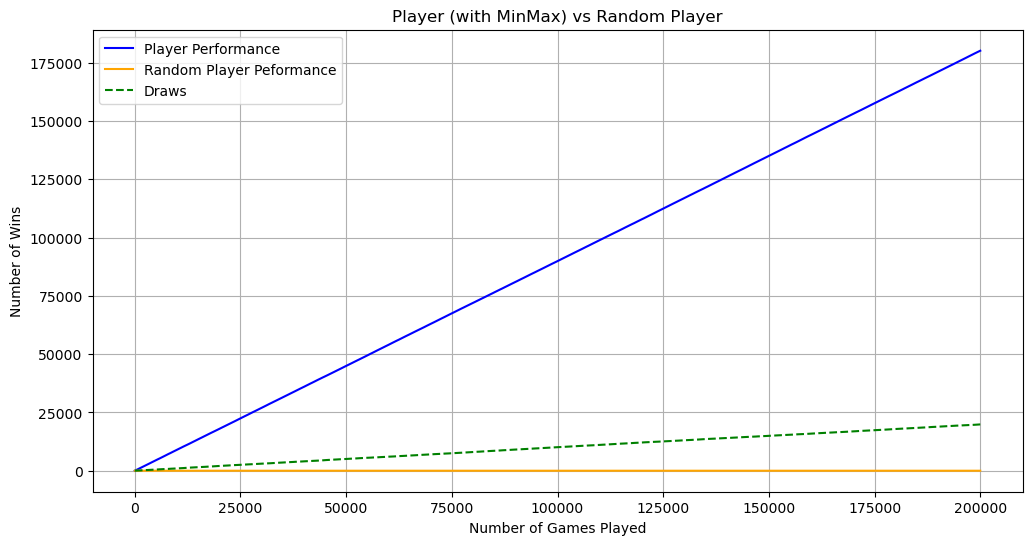

In [19]:
plotWinOverTime(performancePlayer, performanceRandom, performanceDraws, 
                'Random Player Peformance', 'Player (with MinMax) vs Random Player', 'WOT_MinMax_vs_RandomPlayer')

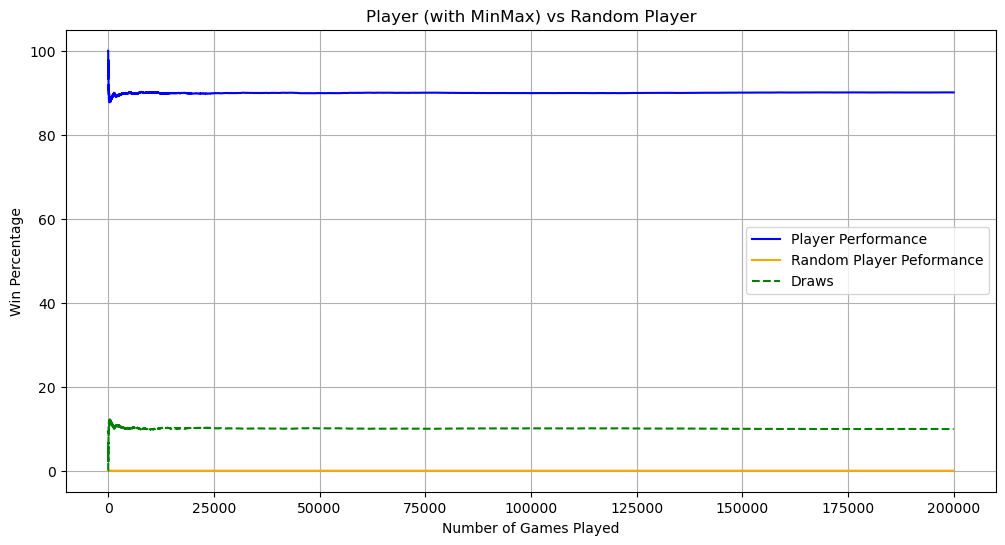

In [20]:
plotWinPercentages(performancePlayer, performanceRandom, performanceDraws, 
                   'Random Player Peformance', 'Player (with MinMax) vs Random Player', 'WP_MinMax_vs_RandomPlayer')

<b> Conclusion: Pitting a Random Player Against MinMax </b> <br>
The results are exactly what we expect from a deterministic, optimal algorithm playing against randomness.
- The MinMax player wins consistently. Out of 200,000 games, it wins ~180,000 (90%). There is no deviation or learning curve — it plays optimally from the start.
- The random player is effectively useless. Its win count is zero. This confirms that, in a fully observable game like Tic Tac Toe, random decisions stand no chance against perfect play.
- Around 10% of games result in draws, likely due to the random player occasionally blocking winning lines by accident.

There’s nothing surprising here, this experiment is mostly to validate that the MinMax implementation behaves as expected: unbeatable, consistent, and stable. It also serves as a good benchmark to compare learning agents later.

## Q-Table and Related Parameters

In [21]:
Qtable = {"XXXXXXXXX": np.zeros(9)}
QtableFreqTracker = {"XXXXXXXXX": 0}
alpha = 0.1
epsilon = 1.0
decayFactor = 0.999
discountFactor = 0.95

## Training Loop

In [22]:
gameNumber = 0
winsPlayer, winsAI, draws = 0, 0, 0
performanceAI, performancePlayer, performanceDraws = [], [], []
decayTracker = []
stateExplorationTracker = []
while(gameNumber < 200000):
    isPlayerPlayingFirst = np.random.choice([True, False])
    currentPlayer, currentSymbol = 1, 1 # Player
    if(isPlayerPlayingFirst == False):
        currentPlayer, currentSymbol = 0, 0 # AI
    gameOver = False
    currentBoard = gameBoard.copy()
    previousBoard, previousAIPositionPlayed = None, None
    stateEpisodes = []
    while(gameOver == False):
        if(currentSymbol == 1):
            currentBoard, position = makeRandomMove(currentBoard, currentSymbol)
        else:
            previousBoard = currentBoard.copy()
            boardString = getBoardString(currentBoard)
            if(boardString not in Qtable):
                Qtable[boardString] = np.zeros(9)
                QtableFreqTracker[boardString] = 0
            QtableFreqTracker[boardString] += 1
            if(np.random.random() < epsilon):
                currentBoard, position = makeRandomMove(currentBoard, currentSymbol)
            else:
                currentBoard, position = makeBestMove(Qtable, boardString, currentBoard, currentSymbol)
            previousAIPositionPlayed = position
            stateEpisodes.append([previousBoard, previousAIPositionPlayed])
        score = getGameStatus(currentBoard, currentSymbol)
        if(score == 1 or score == 0):
            gameOver = True
            if(currentSymbol == 1 and score == 1):
                winsPlayer += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_LOSS, alpha, discountFactor)
            elif(currentSymbol == 0 and score == 1):
                winsAI += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_WIN, alpha, discountFactor)
            else:
                draws += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_DRAW, alpha, discountFactor)
        else:
            if(previousAIPositionPlayed != None):
                updateQTable(Qtable, stateEpisodes, REWARD_ON_NEUTRAL_STATE, alpha, discountFactor)
        currentSymbol = currentSymbol ^ 1
    gameNumber += 1
    if(gameNumber > 0 and gameNumber % 100 == 0):
        epsilon = max(0.2, epsilon * decayFactor)
    decayTracker.append([gameNumber, epsilon])
    stateExplorationTracker.append([gameNumber, len(Qtable)])
    performanceAI.append([gameNumber, winsAI])
    performancePlayer.append([gameNumber, winsPlayer])
    performanceDraws.append([gameNumber, draws])

    if(gameNumber % 10000 == 0):
        print(f"Game Number: {gameNumber}, Player Wins: {performancePlayer[-1]}, AI Wins: {performanceAI[-1]}, Draws: {draws}")

Game Number: 10000, Player Wins: [10000, 4211], AI Wins: [10000, 4521], Draws: 1268
Game Number: 20000, Player Wins: [20000, 8055], AI Wins: [20000, 9394], Draws: 2551
Game Number: 30000, Player Wins: [30000, 11647], AI Wins: [30000, 14564], Draws: 3789
Game Number: 40000, Player Wins: [40000, 14871], AI Wins: [40000, 20074], Draws: 5055
Game Number: 50000, Player Wins: [50000, 17810], AI Wins: [50000, 25888], Draws: 6302
Game Number: 60000, Player Wins: [60000, 20513], AI Wins: [60000, 31947], Draws: 7540
Game Number: 70000, Player Wins: [70000, 22948], AI Wins: [70000, 38278], Draws: 8774
Game Number: 80000, Player Wins: [80000, 25118], AI Wins: [80000, 44878], Draws: 10004
Game Number: 90000, Player Wins: [90000, 27134], AI Wins: [90000, 51678], Draws: 11188
Game Number: 100000, Player Wins: [100000, 28960], AI Wins: [100000, 58747], Draws: 12293
Game Number: 110000, Player Wins: [110000, 30502], AI Wins: [110000, 66061], Draws: 13437
Game Number: 120000, Player Wins: [120000, 32007

In [23]:
winsPlayer, winsAI, draws

(40670, 136909, 22421)

In [24]:
print("Number of Possible States covered: ", len(Qtable))

Number of Possible States covered:  4520


## Plot performance of AI & Player over time

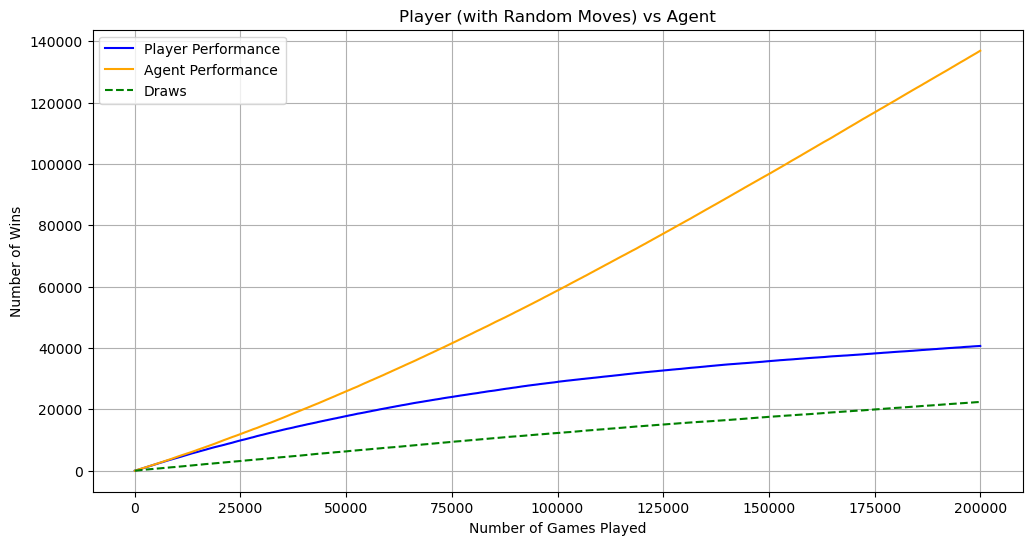

In [25]:
plotWinOverTime(performancePlayer, performanceAI, performanceDraws, 
                'Agent Performance', 'Player (with Random Moves) vs Agent', 'WOT_RandomPlayer_vs_Agent')

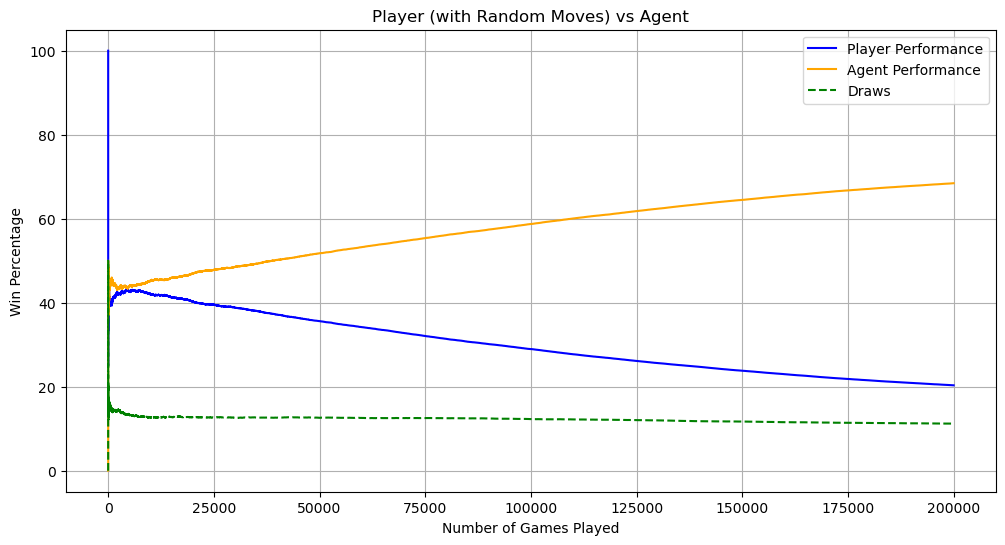

In [26]:
plotWinPercentages(performancePlayer, performanceAI, performanceDraws,
                   'Agent Performance', 'Player (with Random Moves) vs Agent', 'WP_RandomPlayer_vs_Agent')

## Epsilon decay over Time

In [27]:
minDecay = np.inf
minDecayGameNumber = None
for x in decayTracker:
    if(x[1] < minDecay):
        minDecayGameNumber = x[0]
        minDecay = x[1]

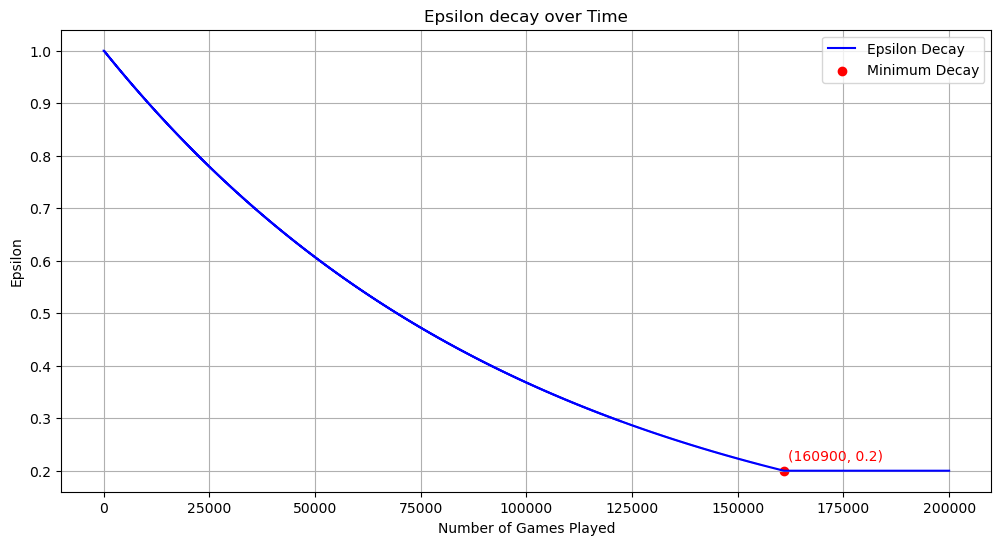

In [28]:
plt.figure(figsize=(12, 6))

numberOfGamesX, epsilonY  = zip(*decayTracker)
plt.plot(numberOfGamesX, epsilonY, label = 'Epsilon Decay', color = 'blue')
plt.scatter(minDecayGameNumber, minDecay, label = 'Minimum Decay', color = 'red')
plt.annotate(
    f'{minDecayGameNumber, minDecay}', xy = (minDecayGameNumber, minDecay),
    xytext = (minDecayGameNumber + 1000, minDecay + 0.02), fontsize = 10, color = 'red'
)

# Adding titles and labels
plt.title('Epsilon decay over Time')
plt.xlabel('Number of Games Played')
plt.ylabel('Epsilon')
plt.grid(True)
plt.legend()
plt.show()

<b> Conclusion: Training Agent Against Random Player </b> <br>
Over 200,000 training games, the Q-learning agent shows clear learning behavior and progressively improves its performance against a random-move opponent. Toward the end of training, the agent stabilizes at roughly a 68–70% win rate, while the random player drops to around 20%, with the remaining games resulting in draws.

During early training, performance is unstable due to high exploration (ε = 1.0), leading to near-random play by both sides. As ε gradually decays and the agent shifts toward exploitation, its win rate consistently increases, demonstrating successful value function learning and policy refinement.

The random opponent reaches its maximum capability immediately as expected, since it does not learn or adapt. Meanwhile, the agent continues to improve by updating Q-values and learning effective board strategies over time.

These results highlight the ability of Q-learning to outperform non-strategic opponents through iterative self-improvement. Although optimal Tic-Tac-Toe play leads to frequent draws, the experiment confirms that the agent learns to reliably beat sub-optimal strategies and converges toward a strong winning policy under this training setup.

## HeatMap for Most Frequent States

In [29]:
# Get the 9 most frequent states based on their occurrence count
top9States = sorted(QtableFreqTracker.items(), key = lambda x: x[1], reverse = True)[:9]
nineStates = []
qTableFor9States = []
for i, (state, freq) in enumerate(top9States, 1):
    print(f"{i}. State: {state}, Frequency: {freq}")
    nineStates.append(state)
    qTableFor9States.append(Qtable[state])

1. State: XXXXXXXXX, Frequency: 100355
2. State: XXXX1XXXX, Frequency: 11237
3. State: XXXXXXXX1, Frequency: 11138
4. State: XXXXXX1XX, Frequency: 11119
5. State: 1XXXXXXXX, Frequency: 11094
6. State: XXXXXXX1X, Frequency: 11093
7. State: XX1XXXXXX, Frequency: 11061
8. State: X1XXXXXXX, Frequency: 11047
9. State: XXXXX1XXX, Frequency: 11024


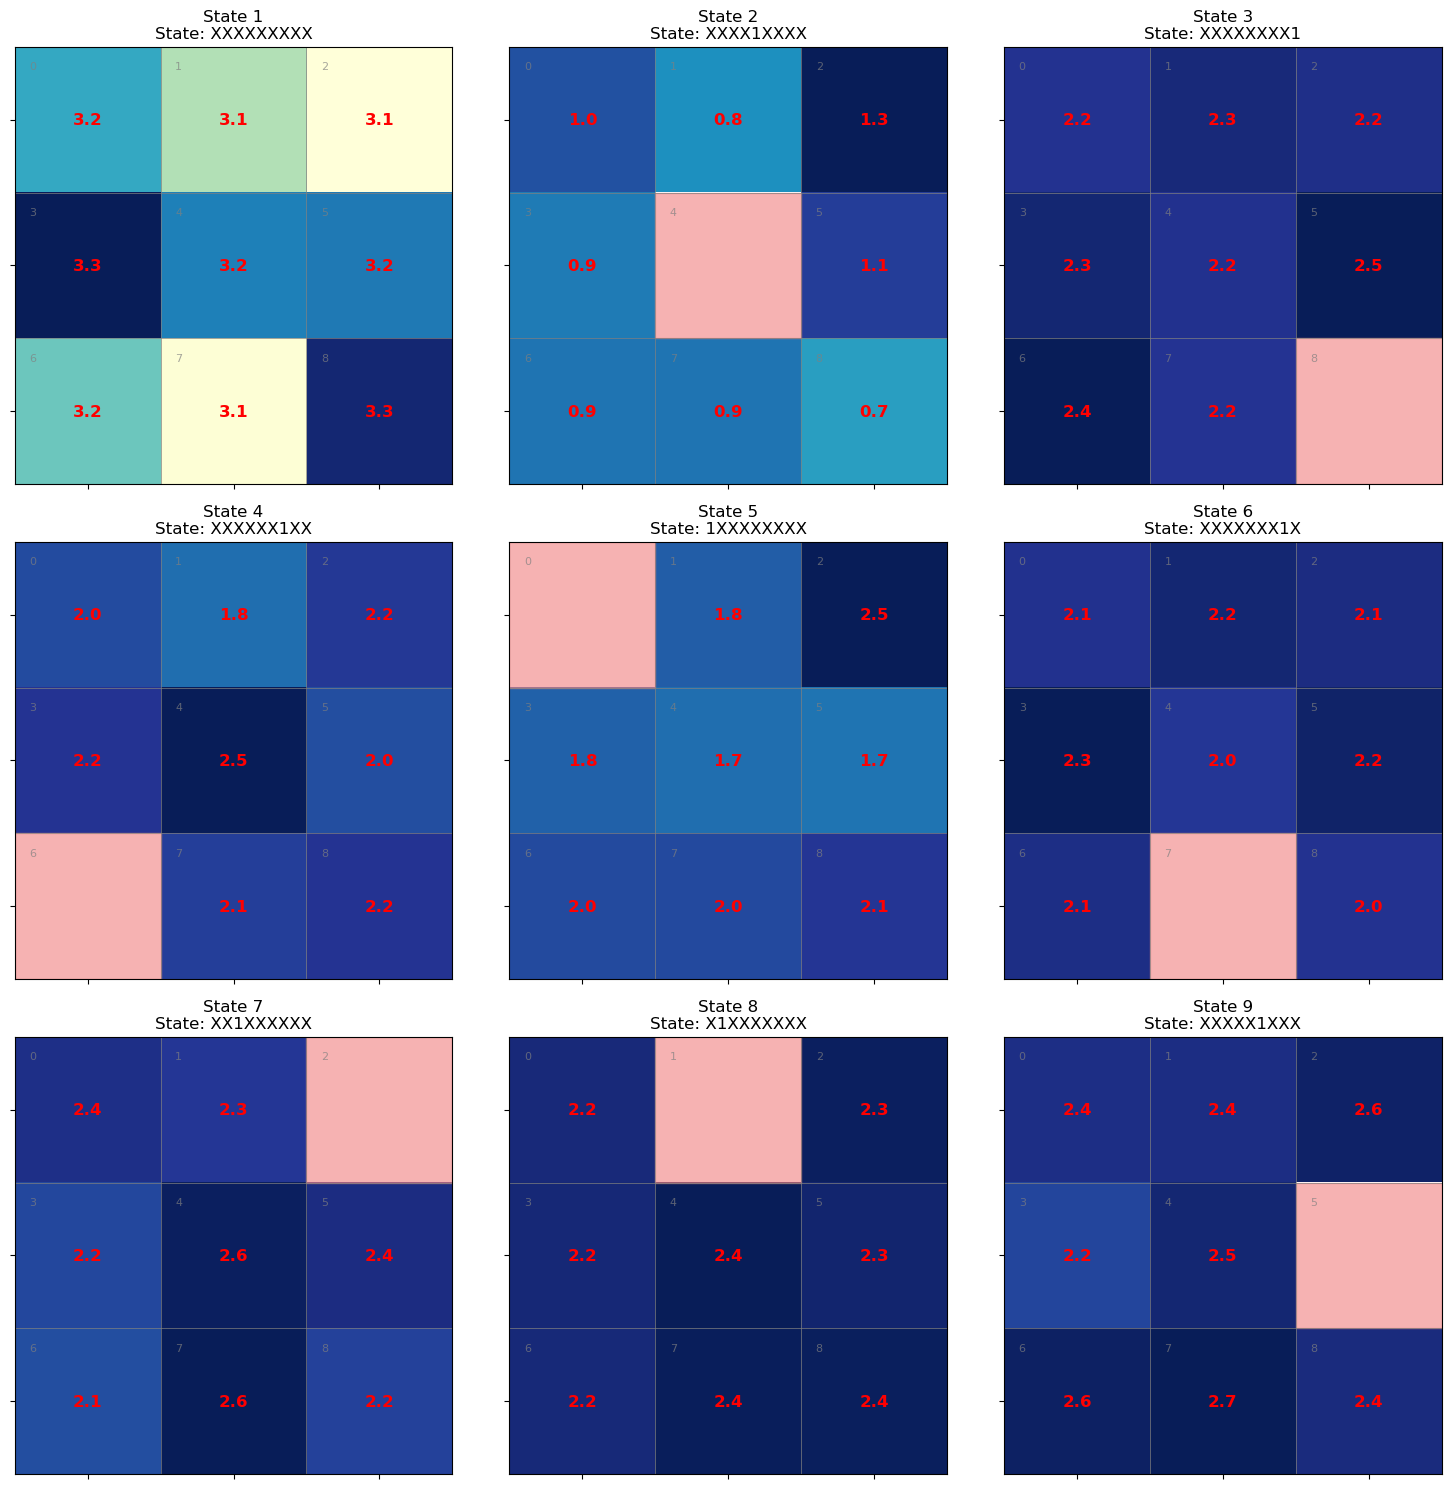

In [30]:
plotTopFrequentStateHeatmaps(nineStates, qTableFor9States, n = 9, title = 'heatMap_Agent_vs_RandomPlayer')

## States Explored over Time

In [31]:
maxStates = -np.inf
maxStatesGameNumber = None
for x in stateExplorationTracker:
    if(x[1] > maxStates):
        maxStatesGameNumber = x[0]
        maxStates = x[1]

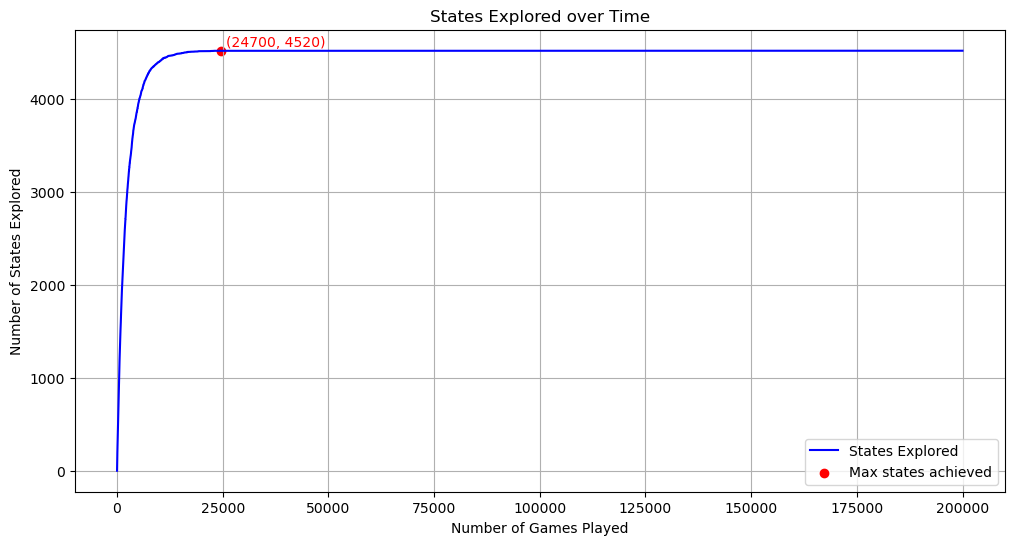

In [32]:
plt.figure(figsize=(12, 6))

numberOfGamesX, numberOfStatesY  = zip(*stateExplorationTracker)
plt.plot(numberOfGamesX, numberOfStatesY, label = 'States Explored', color = 'blue')
plt.scatter(maxStatesGameNumber, maxStates, label = 'Max states achieved', color = 'red')
plt.annotate(
    f'{maxStatesGameNumber, maxStates}', xy = (maxStatesGameNumber, maxStates),
    xytext = (maxStatesGameNumber + 1000, maxStates + 50), fontsize = 10, color = 'red'
)

# Adding titles and labels
plt.title('States Explored over Time')
plt.xlabel('Number of Games Played')
plt.ylabel('Number of States Explored')
plt.grid(True)
plt.legend()
plt.show()

## Playing Against MinMax Algorithm

In [33]:
gameNumber = 0
winsPlayer, winsAI, draws = 0, 0, 0
performanceAI, performancePlayer, performanceDraws = [], [], []
while(gameNumber < 200000):
    isPlayerPlayingFirst = np.random.choice([True, False])
    currentPlayer, currentSymbol = 1, 1 # Player
    if(isPlayerPlayingFirst == False):
        currentPlayer, currentSymbol = 0, 0 # AI
    gameOver = False
    currentBoard = gameBoard.copy()
    while(gameOver == False):
        if(currentSymbol == 1):
            boardString = getBoardString(currentBoard)
            if(boardString in bestMovesDictionary):
                xCoord, yCoord = bestMovesDictionary[boardString]
                currentBoard[xCoord][yCoord] = currentSymbol
            else:
                currentBoard, position = playerBestMove(currentBoard, currentSymbol)
                bestMovesDictionary[boardString] = position
        else:
            boardString = getBoardString(currentBoard)
            if(boardString not in Qtable):
                Qtable[boardString] = np.zeros(9)
            currentBoard, position = makeBestMove(Qtable, boardString, currentBoard, currentSymbol)
        score = getGameStatus(currentBoard, currentSymbol)
        if(score == 1 or score == 0):
            gameOver = True
            if(currentSymbol == 1 and score == 1):
                winsPlayer += 1
            elif(currentSymbol == 0 and score == 1):
                winsAI += 1
            else:
                draws += 1
        # print(currentBoard)
        currentSymbol = currentSymbol ^ 1
    gameNumber += 1
    performanceAI.append([gameNumber, winsAI])
    performancePlayer.append([gameNumber, winsPlayer])
    performanceDraws.append([gameNumber, draws])

    if(gameNumber % 10000 == 0):
        print(f"Game Number: {gameNumber}, Player Wins: {performancePlayer[-1]}, AI Wins: {performanceAI[-1]}, Draws: {draws}")

Game Number: 10000, Player Wins: [10000, 5008], AI Wins: [10000, 0], Draws: 4992
Game Number: 20000, Player Wins: [20000, 9952], AI Wins: [20000, 0], Draws: 10048
Game Number: 30000, Player Wins: [30000, 14955], AI Wins: [30000, 0], Draws: 15045
Game Number: 40000, Player Wins: [40000, 19860], AI Wins: [40000, 0], Draws: 20140
Game Number: 50000, Player Wins: [50000, 24879], AI Wins: [50000, 0], Draws: 25121
Game Number: 60000, Player Wins: [60000, 29859], AI Wins: [60000, 0], Draws: 30141
Game Number: 70000, Player Wins: [70000, 34873], AI Wins: [70000, 0], Draws: 35127
Game Number: 80000, Player Wins: [80000, 39857], AI Wins: [80000, 0], Draws: 40143
Game Number: 90000, Player Wins: [90000, 44846], AI Wins: [90000, 0], Draws: 45154
Game Number: 100000, Player Wins: [100000, 49872], AI Wins: [100000, 0], Draws: 50128
Game Number: 110000, Player Wins: [110000, 54894], AI Wins: [110000, 0], Draws: 55106
Game Number: 120000, Player Wins: [120000, 59853], AI Wins: [120000, 0], Draws: 6014

In [34]:
print("Number of Possible States covered: ", len(Qtable))

Number of Possible States covered:  4520


## Plot performance of AI & Player (with MinMax) over time

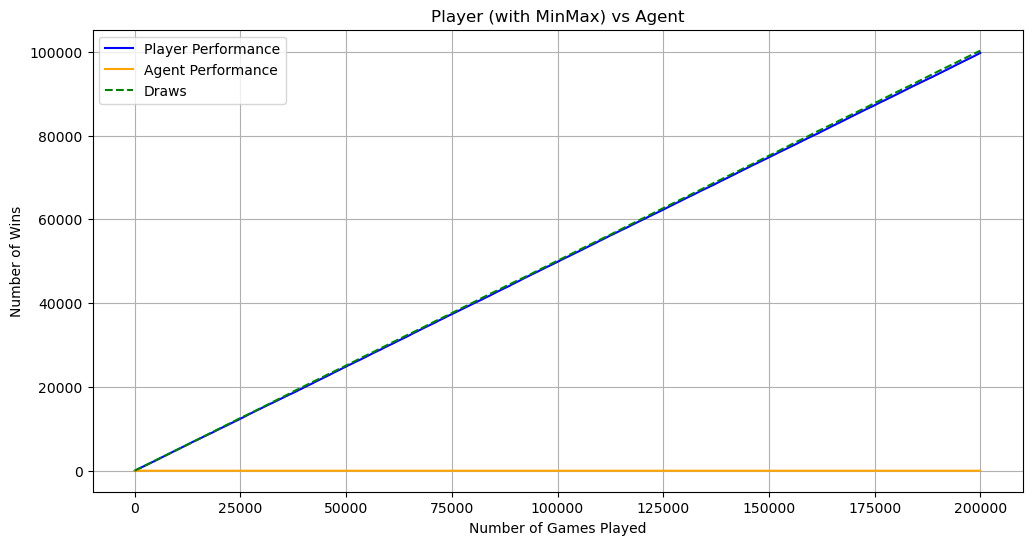

In [35]:
plotWinOverTime(performancePlayer, performanceAI, performanceDraws, 
                'Agent Performance', 'Player (with MinMax) vs Agent', 'WOT_MinMax_vs_Agent')

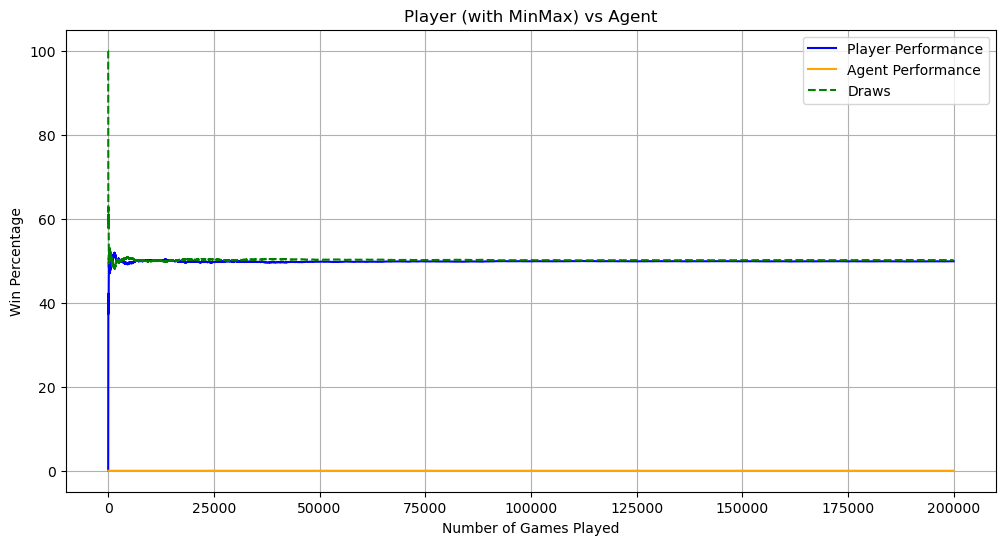

In [36]:
plotWinPercentages(performancePlayer, performanceAI, performanceDraws,
                   'Agent Performance', 'Player (with MinMax) vs Agent', 'WP_MinMax_vs_Agent')

<b> Conclusion: Agent vs MinMax — Performance and Learned Priorities </b> <br>
When pitted against the MinMax player, the agent fails to register a single win across 200,000 games. The entire win count is split between the MinMax player and draws, with a roughly 50-50 distribution. The agent is unable to improve or adapt once it reaches its exploitation phase, and the win percentage graph confirms this i.e. the orange line (agent) remains flat at 0% throughout.

While this result highlights the dominance of MinMax, it also exposes the limitations of the current agent. It has learned just enough to avoid losing every single game, but not enough to pose a threat. The draw rate is a mild consolation, the agent manages to force stalemates in half of the games, suggesting that it can sometimes block immediate threats but lacks any proactive planning.

This limited capability is echoed in the heatmap visualizations of the most frequent board states. Across all 9 states, the agent rarely prioritizes the center square, arguably the most strategic position in Tic Tac Toe. Instead, Q-values are spread relatively evenly across available cells, indicating shallow or non-strategic value learning. There's no clear positional hierarchy, no consistent corner-center-side bias, and no reinforcement of opening principles.

In short, the agent has learned to avoid obvious blunders, but its policies lack deeper structure. Without targeted reward shaping or stronger opponents during training, it fails to internalize even basic priorities like controlling the center. While it can survive against random play, it’s nowhere near competent against optimal opponents.

## Save the Model (if it's Good)

In [37]:
if performancePlayer[-1][1] == 0:
    with open("failed_Qtable.txt", "w") as f:
        for board_string, q_values in Qtable.items():
            f.write(f"{board_string}: {q_values.tolist()}\n")
    print("Model saved!!")

In [38]:
Qtable['XXXXXXXXX']

array([3.19902243, 3.13387851, 3.06124528, 3.31345085, 3.22917016,
       3.23345317, 3.16556677, 3.06477025, 3.29884724])

## Update Reward Function

This function introduces a subtle but purposeful modification aimed at addressing one of the agent's most apparent weaknesses — its failure to prioritize the center square, as revealed in the heatmap analysis. Despite extensive training, the agent showed no meaningful bias toward strategic positions, especially the center, which is often critical for controlling the game.

To counter this, the function includes a one-time bonus Q-value update when the agent selects the center position (1, 1) as its first move. By injecting a small positive reinforcement early in the episode, this reward shaping encourages the agent to explore and value the center more explicitly — something it failed to learn on its own through standard exploration and TD updates.

This intervention doesn’t change the learning algorithm fundamentally, but it introduces domain knowledge in a light-touch, interpretable way. It's a step toward overcoming the shallow, evenly distributed Q-values and helping the agent develop more structured, tactically sound policies — especially when facing optimal opponents like MinMax, where passive survival strategies are not enough.


## Updated Q-Learning Formula (with center block reward)

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right] + \delta_c
$$

Where:

$$
\delta_c =
\begin{cases}
0.1, & \text{if this is the first move and } a = \text{center (1,1)} \\
0, & \text{otherwise}
\end{cases}
$$


In [39]:
def updateQTable(qTable, episodes, reward, a, df):
    """
    Updates the Q-table using the Temporal Difference (TD) learning rule based on the 
    current state, the action taken, the received reward, and the future state's estimated value.

    Parameters:
        qTable (dict): A dictionary representing the Q-table, where keys are board state strings 
                       and values are lists of Q-values for each action (position).
        board (np.ndarray): A 3x3 NumPy array representing the next board state after the move.
        position (int): The index (0–8) representing the action taken in the previous state.
        reward (float): The immediate reward received after taking the action.
        a (float): The learning rate (alpha), determining how much new information overrides old.
        df (float): The discount factor (gamma), representing the importance of future rewards.

    Returns:
        None
    """
    counter = 0
    for state in episodes:
        board, position = state
        index = position[0] * 3 + position[1]
        boardString = getBoardString(board)
        if(boardString not in qTable):
            qTable[boardString] = np.zeros(9)
        qTable[boardString][index] +=  (reward + df * max(qTable[boardString]) - qTable[boardString][index]) * a
        if(counter == 0 and position == (1, 1)):
            qTable[boardString][index] += 0.1  # Reward for choosing the Center Block for the first Move.
            counter = 1

## Q-Table and Related Parameters

In [40]:
Qtable = {"XXXXXXXXX": np.zeros(9)}
alpha = 0.1
epsilon = 1.0
decayFactor = 0.999
discountFactor = 0.95

## Training Loop

In [41]:
gameNumber = 0
winsPlayer, winsAI, draws = 0, 0, 0
performanceAI, performancePlayer, performanceDraws = [], [], []
# decayTracker = True

while(gameNumber < 200000):
    isPlayerPlayingFirst = np.random.choice([True, False])
    currentPlayer, currentSymbol = 1, 1 # Player
    if(isPlayerPlayingFirst == False):
        currentPlayer, currentSymbol = 0, 0 # AI
    gameOver = False
    currentBoard = gameBoard.copy()
    previousBoard, previousAIPositionPlayed = None, None
    stateEpisodes = []
    while(gameOver == False):
        if(currentSymbol == 1):
            currentBoard, position = makeRandomMove(currentBoard, currentSymbol)
        else:
            previousBoard = currentBoard.copy()
            boardString = getBoardString(currentBoard)
            if(boardString not in Qtable):
                Qtable[boardString] = np.zeros(9)
            
            if(np.random.random() < epsilon):
                currentBoard, position = makeRandomMove(currentBoard, currentSymbol)
            else:
                currentBoard, position = makeBestMove(Qtable, boardString, currentBoard, currentSymbol)
            previousAIPositionPlayed = position
            stateEpisodes.append([previousBoard, previousAIPositionPlayed])
        score = getGameStatus(currentBoard, currentSymbol)
        if(score == 1 or score == 0):
            gameOver = True
            if(currentSymbol == 1 and score == 1):
                winsPlayer += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_LOSS, alpha, discountFactor)
            elif(currentSymbol == 0 and score == 1):
                winsAI += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_WIN, alpha, discountFactor)
            else:
                draws += 1
                updateQTable(Qtable, stateEpisodes, REWARD_ON_DRAW, alpha, discountFactor)
        else:
            if(previousAIPositionPlayed != None):
                updateQTable(Qtable, stateEpisodes, REWARD_ON_NEUTRAL_STATE, alpha, discountFactor)
        currentSymbol = currentSymbol ^ 1
    gameNumber += 1
    if(gameNumber > 0 and gameNumber % 100 == 0):
        epsilon = max(0.2, epsilon * decayFactor)
        # if(epsilon == 0.2 and decayTracker == True):
        #     decayTracker = False
    performanceAI.append([gameNumber, winsAI])
    performancePlayer.append([gameNumber, winsPlayer])
    performanceDraws.append([gameNumber, draws])

    if(gameNumber % 10000 == 0):
        print(f"Game Number: {gameNumber}, Player Wins: {performancePlayer[-1]}, AI Wins: {performanceAI[-1]}, Draws: {draws}")

Game Number: 10000, Player Wins: [10000, 4202], AI Wins: [10000, 4579], Draws: 1219
Game Number: 20000, Player Wins: [20000, 7917], AI Wins: [20000, 9604], Draws: 2479
Game Number: 30000, Player Wins: [30000, 11267], AI Wins: [30000, 14982], Draws: 3751
Game Number: 40000, Player Wins: [40000, 14255], AI Wins: [40000, 20720], Draws: 5025
Game Number: 50000, Player Wins: [50000, 16964], AI Wins: [50000, 26852], Draws: 6184
Game Number: 60000, Player Wins: [60000, 19336], AI Wins: [60000, 33241], Draws: 7423
Game Number: 70000, Player Wins: [70000, 21513], AI Wins: [70000, 39931], Draws: 8556
Game Number: 80000, Player Wins: [80000, 23366], AI Wins: [80000, 46905], Draws: 9729
Game Number: 90000, Player Wins: [90000, 25069], AI Wins: [90000, 54161], Draws: 10770
Game Number: 100000, Player Wins: [100000, 26575], AI Wins: [100000, 61635], Draws: 11790
Game Number: 110000, Player Wins: [110000, 27954], AI Wins: [110000, 69294], Draws: 12752
Game Number: 120000, Player Wins: [120000, 29187]

## HeatMap for Most Frequent States

In [42]:
qTableFor9States = []
for state in nineStates:
    qTableFor9States.append(Qtable[state])

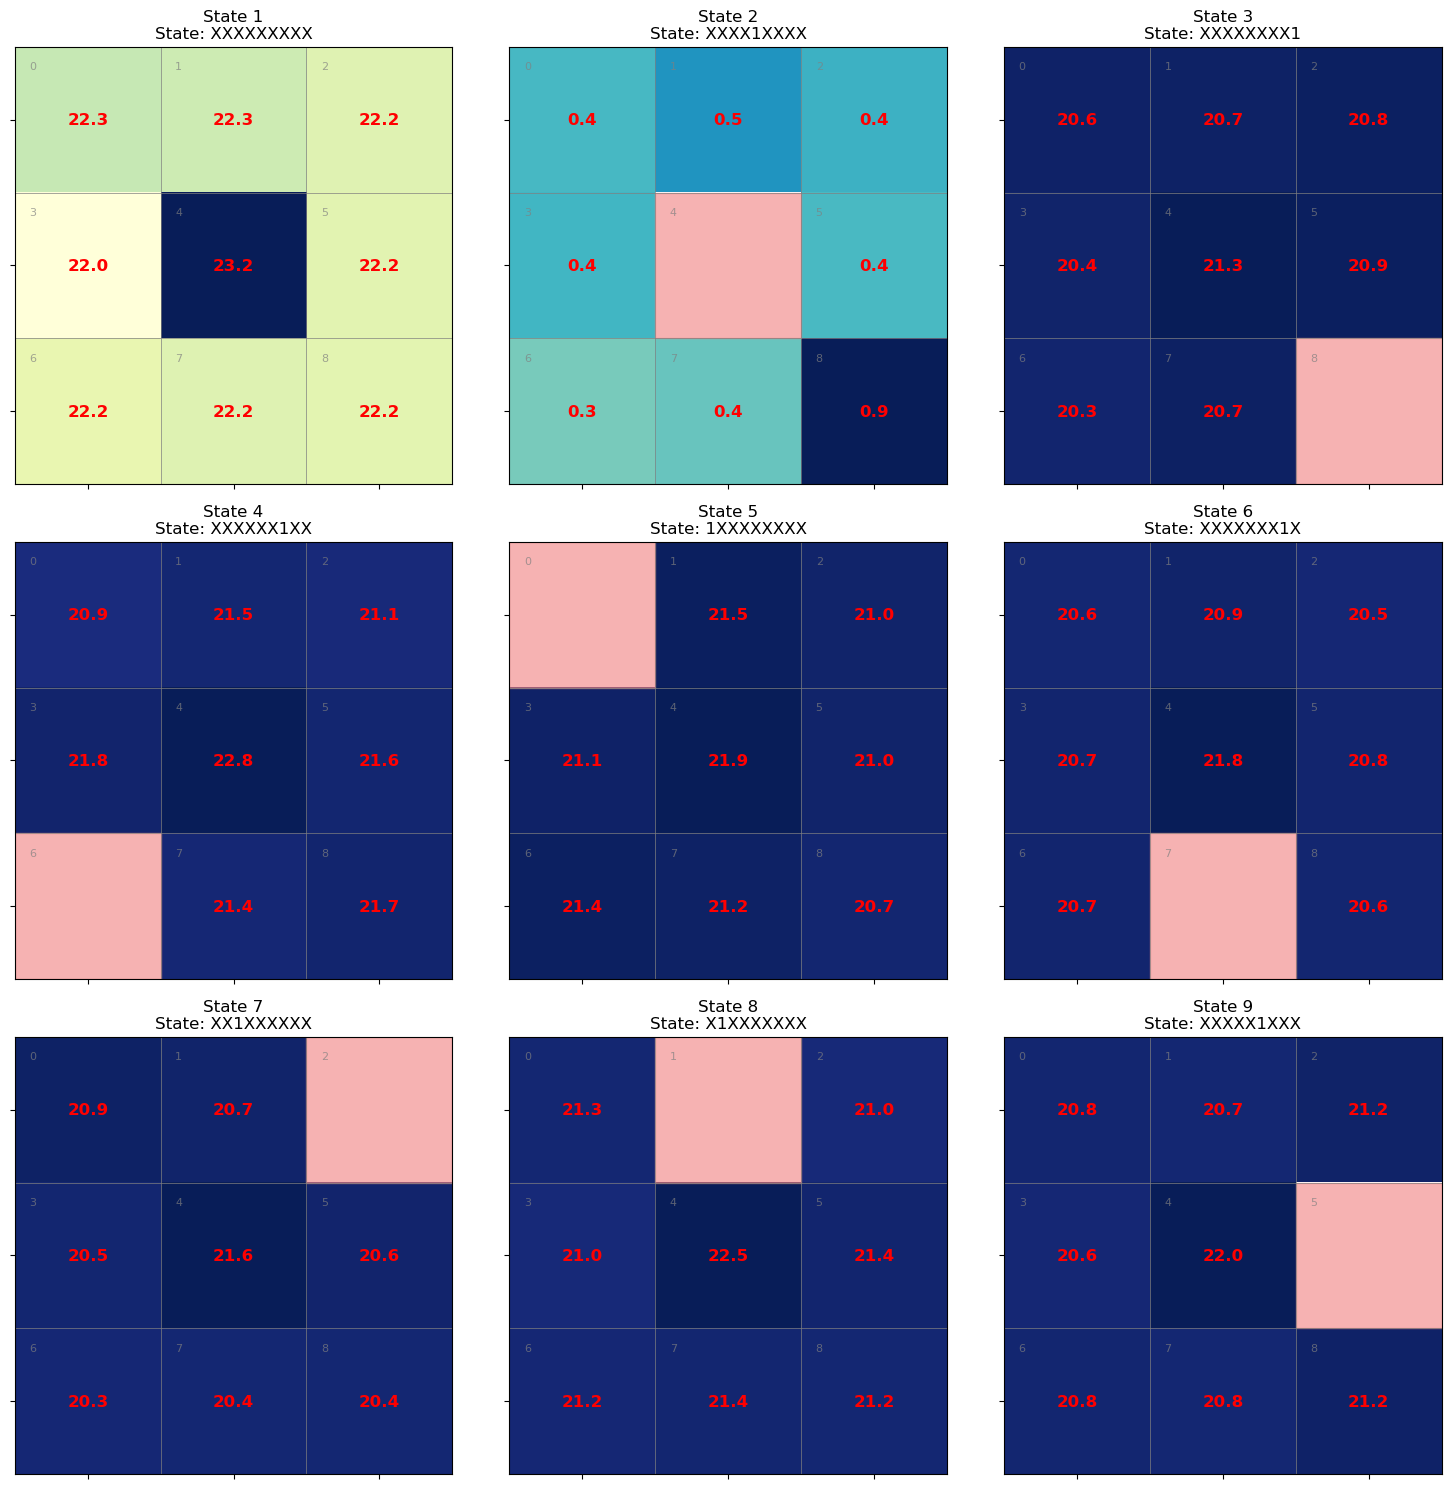

In [43]:
plotTopFrequentStateHeatmaps(nineStates, qTableFor9States, n = 9, title = 'heatMap_Agent_updatedRewards_vs_MinMax')

## Let's play against MinMax Algorithm again

In [44]:
gameNumber = 0
winsPlayer, winsAI, draws = 0, 0, 0
performanceAI, performancePlayer, performanceDraws = [], [], []
while(gameNumber < 200000):
    isPlayerPlayingFirst = np.random.choice([True, False])
    currentPlayer, currentSymbol = 1, 1 # Player
    if(isPlayerPlayingFirst == False):
        currentPlayer, currentSymbol = 0, 0 # AI
    gameOver = False
    currentBoard = gameBoard.copy()
    while(gameOver == False):
        if(currentSymbol == 1):
            boardString = getBoardString(currentBoard)
            if(boardString in bestMovesDictionary):
                xCoord, yCoord = bestMovesDictionary[boardString]
                currentBoard[xCoord][yCoord] = currentSymbol
            else:
                currentBoard, position = playerBestMove(currentBoard, currentSymbol)
                bestMovesDictionary[boardString] = position
        else:
            boardString = getBoardString(currentBoard)
            if(boardString not in Qtable):
                Qtable[boardString] = np.zeros(9)
            currentBoard, position = makeBestMove(Qtable, boardString, currentBoard, currentSymbol)
        score = getGameStatus(currentBoard, currentSymbol)
        if(score == 1 or score == 0):
            gameOver = True
            if(currentSymbol == 1 and score == 1):
                winsPlayer += 1
            elif(currentSymbol == 0 and score == 1):
                winsAI += 1
            else:
                draws += 1
        # print(currentBoard)
        currentSymbol = currentSymbol ^ 1
    gameNumber += 1
    performanceAI.append([gameNumber, winsAI])
    performancePlayer.append([gameNumber, winsPlayer])
    performanceDraws.append([gameNumber, draws])

    if(gameNumber % 10000 == 0):
        print(f"Game Number: {gameNumber}, Player Wins: {performancePlayer[-1]}, AI Wins: {performanceAI[-1]}, Draws: {draws}")

Game Number: 10000, Player Wins: [10000, 0], AI Wins: [10000, 0], Draws: 10000
Game Number: 20000, Player Wins: [20000, 0], AI Wins: [20000, 0], Draws: 20000
Game Number: 30000, Player Wins: [30000, 0], AI Wins: [30000, 0], Draws: 30000
Game Number: 40000, Player Wins: [40000, 0], AI Wins: [40000, 0], Draws: 40000
Game Number: 50000, Player Wins: [50000, 0], AI Wins: [50000, 0], Draws: 50000
Game Number: 60000, Player Wins: [60000, 0], AI Wins: [60000, 0], Draws: 60000
Game Number: 70000, Player Wins: [70000, 0], AI Wins: [70000, 0], Draws: 70000
Game Number: 80000, Player Wins: [80000, 0], AI Wins: [80000, 0], Draws: 80000
Game Number: 90000, Player Wins: [90000, 0], AI Wins: [90000, 0], Draws: 90000
Game Number: 100000, Player Wins: [100000, 0], AI Wins: [100000, 0], Draws: 100000
Game Number: 110000, Player Wins: [110000, 0], AI Wins: [110000, 0], Draws: 110000
Game Number: 120000, Player Wins: [120000, 0], AI Wins: [120000, 0], Draws: 120000
Game Number: 130000, Player Wins: [13000

<b> Conclusion: Impact of Reward Shaping via Modified Update Function </b> <br>
These two outputs, the updated heatmaps and the gameplay statistics, clearly show the effect of modifying the Q-value update strategy.

After introducing a targeted reward bonus for selecting the center square on the first move, the agent’s behavior changed significantly:

The heatmaps now consistently reflect higher Q-values at the center position (index 4) across multiple states. This contrasts sharply with earlier results, where the agent failed to prioritize the center at all. The strategic importance of that square is now encoded into the learned policy.

In the MinMax matchup, the agent reaches zero-loss performance across 200,000 games. Every single game ends in a draw. This is a massive leap from previous experiments, where the agent was consistently losing about 50% of its games. The objective here is not to beat MinMax; that is not possible. The goal is to survive, and in this case the agent never loses.

This improvement is a direct result of rewarding the right opening behavior. By encouraging early control of the center, the agent learned to defend more effectively, block winning lines, and hold out for a draw. The result demonstrates that minimal, well-placed reward shaping can meaningfully guide learning and yield practical, game-aware behavior, even when full optimality is not achievable.

## Save the Model

In [45]:
if performancePlayer[-1][1] == 0:
    with open("failed_Qtable_withRewardModification.txt", "w") as f:
        for board_string, q_values in Qtable.items():
            f.write(f"{board_string}: {q_values.tolist()}\n")
    print("Model saved!!")

Model saved!!


In [46]:
Qtable['XXXXXXXXX']

array([22.28912516, 22.26003254, 22.18707452, 21.97487448, 23.22984103,
       22.17888185, 22.15010585, 22.19364648, 22.17545002])

In [47]:
end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

Execution time: 712.92 seconds
